## Code examples 

### Base case

#### Description

This module helps to create energy efficient solutions for a context recognition problem. It assumes that the problem can be solved using different system's settings (e.g. different frequencies, different feature sets, different sensor subsets etc.) Each of these settings has a different energy cost, but also different classification quality (e.g. accuracy). Settings can be switched in runtime (e.g. using low acceleromter frequency when user is resting, but high when they are running), and this module is tasked with finding good rules for switching between them. It does so in a domain independent way by analyzing the statistical properties of the dataset

First part of the required input is a sequence of contexts (contexts are the classes of the classification system: e.g walking, standing, running in an activity recognition system). This sequence should be representative in both context proportions and their ordering to the sequences expected in the target domain.

In this toy example the contexts are simply numbers 1-3 (they could be strings instead). They represent a domain when each context appears 4 times and then transitions to the one represented by the next number.

In [3]:
sequence = [0,0,0,0,  1,1,1,1,  2,2,2,2, 0]

In this hypothetical case, we have 6 different settings named "a"-"f". Their meaning is irrelevant to this module (perhaps they each represent a different sensor that could be used) and they can be presented by any hashable type. With each setting we classify the data from which the previous sequence was taken and store the results in a dictionary. We also supply the energy cost for using that setting for a one time unit.

In [4]:
classified = {}
classified["a"] = [0,0,0,0,  1,1,1,1,  2,2,2,2, 0]
classified["b"] = [1,1,1,1,  1,1,1,1,  1,1,1,1, 1]
classified["c"] = [0,0,0,0,  2,1,2,1,  2,2,2,0, 0]
classified["d"] = [0,0,0,0,  1,1,1,2,  0,1,2,2, 0]
classified["e"] = [0,0,0,0,  0,0,0,0,  2,2,2,2, 0]
classified["f"] = [1,1,1,1,  1,1,1,1,  2,2,2,2, 1]

energy = {"a":3, "b":1, "c":2, "d":2, "e":1, "f":1}

A brief commentary on the classified sequences: <br />
Using setting "a" generated the same sequence to the original one, representing perfect classification. Its energy cost, however, its higher than all others.<br />
Using setting "b" every instance was classified as "1", but its energy cost was the low. <br /> 
Using setting "c" contexts "0" and "2" are accurately classified, while the context "1" is not. <br />
Using setting "d" contexts "0" and "1" are accurately classified, while the context "2" is not. <br />
Similarly for settings "e" and "f".

All three input paramters are entered into the EnergyOptimizer object.

In [5]:
from eecr import EnergyOptimizer
from eecr import eeutility as util

In [6]:
optimizer = EnergyOptimizer(sequence=sequence, 
                            setting_to_sequence=classified, 
                            setting_to_energy=energy)

#### Data summary

The EnergyOptimizer assumes that the context sequence has the Markov property and in transforms the sequences into the mathematical description of corresponding Markov chains. Some basic properties can be shown.

In [7]:
optimizer.summary()

   Proportions  Average lengths
0     0.333333              4.0
1     0.333333              4.0
2     0.333333              4.0


For each setting, we can check its accuracy and energy consumption (they are shown in a tuple in this order). Accuracy can be substituted with any other quality metric (e.g. f-score) if needed.

In [7]:
optimizer.energy_quality()

{'a': (1.0, 3),
 'b': (0.3333333333333333, 1),
 'c': (0.75, 2),
 'd': (0.75, 2),
 'e': (0.6666666666666667, 1),
 'f': (0.6666666666666667, 1)}

If the desired context recognition system would always use one setting, only three out of six would come into consideration (printed below). Others are pareto dominated (they are worse in both accuracy and energy than one of the other solutions).

In [8]:
solutions, values = optimizer.find_sca_static()
for (s,v) in zip(solutions, values):
    print (s, v)

a (1.0, 3)
c (0.7692307692307693, 2)
e (0.6923076923076923, 1)


#### SCA method

Suppose now, that we wish to change the setting based on the current context. E.g. if context 0 is detected, use setting "a", but for contexts "1" and "2" use settings "d" and "e" respectively. The expected performance of such assignment can be mathematically modeled using the "sca_model" method.

In [9]:
optimizer.sca_model(["d","f","e"])

[(0.9535747446610956, 1.3514391829155061)]

Using this context switching scheme we could achieve 95% accuracy and on average consume 1.35 units of energy.

Note we assigned to use setting "d" when context 0 was detected. Since using this setting both "0" and "1" context are well classified ("1" always succeeds "0"), the assignment yield good results. If we used setting "d" that is good for recognizing contexts "0" and "2" instead, the results worsen.

In [10]:
optimizer.sca_model(["c","f","e"])

[(0.8952062430323299, 1.3801560758082498)]

The mathematical model (beside being much faster then a simulation on a large dataset) can capture some performance anomalies that would otherwise go undetected. For example, if setting "b" is assigned to context "1", all classifications from this point on wozld be "1". This is easy to miss when simulating on this short sequence (sca_real) but is detected by the mathematical model and assigned an appropriate low accuracy.

In [11]:
optimizer.sca_real(["a","b","a"])

[(0.6153846153846154, 1.6153846153846154)]

In [12]:
optimizer.sca_model(["a","b","a"])

[(0.3333333333333332, 1.0)]

Good assignments can be found automatically using the "find_sca_tradeoffs" function.

In [13]:
solutions_sca, values_sca = optimizer.find_sca_tradeoffs()
for (s,v) in zip(solutions_sca, values_sca):
    print (s, v)

['a', 'f', 'e'] (1.0, 1.6666666666666667)
['d', 'f', 'e'] (0.9535747446610956, 1.3514391829155061)
['f', 'f', 'e'] (0.7500000000000002, 1.0)
['b', 'f', 'e'] (0.7500000000000002, 1.0)


Performance can be easily visulized. Lower left corner presents the best solutions. It is immediately appearent that the solutions that use setting switching (SCA solutions) are better than those where the same one is always used (Static).

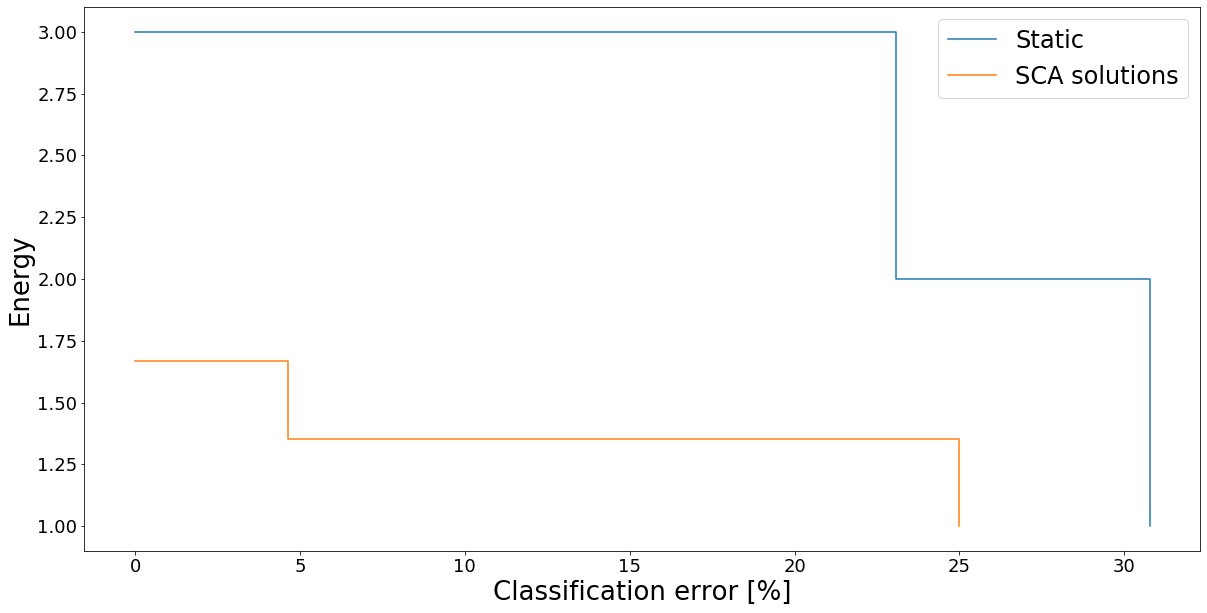

In [14]:
util.draw_tradeoffs([values, values_sca], ["Static", "SCA solutions"])

#### DCA method

Aside of using different settings, one can also use duty cycling. Duty-cycling means that sensors work for a given amount of time, than turn off for a given amount of time and repeat. Similar to the SCA setting switching case, the length of the sleeping period can be dynamically adjusted to the last classified context.

The functions that model the performance of the duty-cycling are similar, but use dca prefix instead of sca. The call below, for example, models how the system would beheave if duty-cycle length when activity "0" is detected would be 1 and so on. Note that duty-cycle length count period in both working and sleeping part of the cycle, thus the minimum for this parameter is 1 (1 period working, 0 periods sleeping).

In [15]:
optimizer.dca_model([1,2,3], setting = "a")

[(0.8682170542635659, 1.6976744186046506)]

Again, the solutions can be automatically found (only a subset is printed).

In [16]:
solutions_dca, values_dca = optimizer.find_dca_tradeoffs(setting = "d", max_cycle=5)

In [17]:
for (s,v) in list(zip(solutions_dca, values_dca))[0:8]:
    print (s, v)

[1, 1, 1] (0.7500000000000001, 2.0)
[1, 1, 2] (0.7336523125996811, 1.6299840510366825)
[1, 2, 1] (0.7214035087719299, 1.5564912280701755)
[1, 2, 2] (0.7209523809523811, 1.3447619047619046)
[1, 2, 3] (0.7018874994145473, 1.1944171233197507)
[1, 3, 2] (0.6903486141430177, 1.1702057286498644)
[1, 3, 3] (0.6790176340401228, 1.0633254801170842)
[2, 2, 2] (0.6770833333333334, 1.0)


#### SCA + DCA method combination

Both axis of optimizations can be joined togeteher, simultaneously switching between both the length of the duty-cycle and different system's settings.

In [18]:
solutions_sca_dca, values_sca_dca = optimizer.find_sca_dca_tradeoffs(max_cycle=5)

In [19]:
for (s,v) in list(zip(solutions_sca_dca, values_sca_dca))[0:8]:
    print (s, v)

['a', 'f', 'e'] (1.0, 1.6666666666666667)
(['d', 'f', 'e'], [1, 1, 1]) (0.9535747446610957, 1.3514391829155064)
['d', 'f', 'e'] (0.9535747446610956, 1.3514391829155061)
(['a', 'f', 'e'], [2, 1, 1]) (0.9523809523809523, 1.1904761904761905)
(['d', 'f', 'e'], [1, 2, 1]) (0.9245284950744742, 1.1644404584582084)
(['a', 'f', 'e'], [2, 1, 2]) (0.9115646258503401, 0.9727891156462587)
(['d', 'f', 'e'], [2, 2, 1]) (0.8793818815385329, 0.8507989372176622)
(['a', 'f', 'e'], [2, 2, 2]) (0.875, 0.8333333333333333)


Solutions from all methods are visualized in the graph below. The method combination (as usual) produced the most energy-efficient solutions.

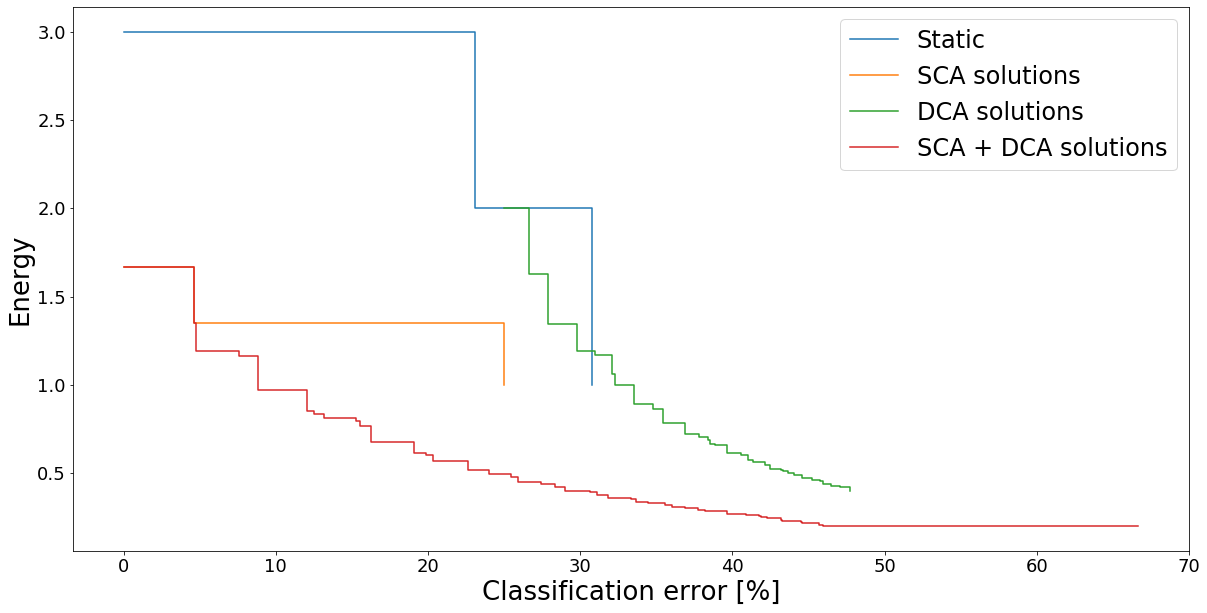

In [20]:
util.draw_tradeoffs([values, values_sca, values_dca, values_sca_dca], 
                ["Static", "SCA solutions", "DCA solutions", "SCA + DCA solutions"])

### Test on real-life SHL dataset

Load the relevant parts of the dataset - the sequence of contexts, settings, their energy cost and misclassifications using each of the settings.

In [21]:
optimizer = EnergyOptimizer()
optimizer.load_data_config(sample_dataset="SHL")

There are eight different contexts in this dataset.

In [22]:
optimizer.contexts

['Bike', 'Bus', 'Car', 'Run', 'Still', 'Subway', 'Train', 'Walking']

In [23]:
optimizer.sequence

0         Run
1       Still
2       Still
3       Still
4       Still
        ...  
4072     Bike
4073     Bike
4074     Bike
4075     Bike
4076    Train
Name: Context, Length: 4077, dtype: object

Settings are sensor subset used. They are encoded in a binary tuple, where each element represents the existance of one sensors. <br />
Sensor order in tuple: accelerometer, magnetometer, barometer, pressure sensor, orientation sensor. <br />
The energy cost of a setting is the number of sensors * 10 

In [24]:
optimizer.setting_to_energy[(1,1,0,0,0)]

20

In [25]:
#The context as predicted using only accelerometer and magnetometer
optimizer.setting_to_sequence[(1,1,0,0,0)]  

0         Run
1         Bus
2         Bus
3       Still
4       Still
        ...  
4072     Bike
4073     Bike
4074     Bike
4075     Bike
4076    Train
Name: 11000, Length: 4077, dtype: object

Now we can run the exact same methods as in the artifical example case

In [26]:
solutions, values = optimizer.find_sca_static()
solutions_sca, values_sca = optimizer.find_sca_tradeoffs()

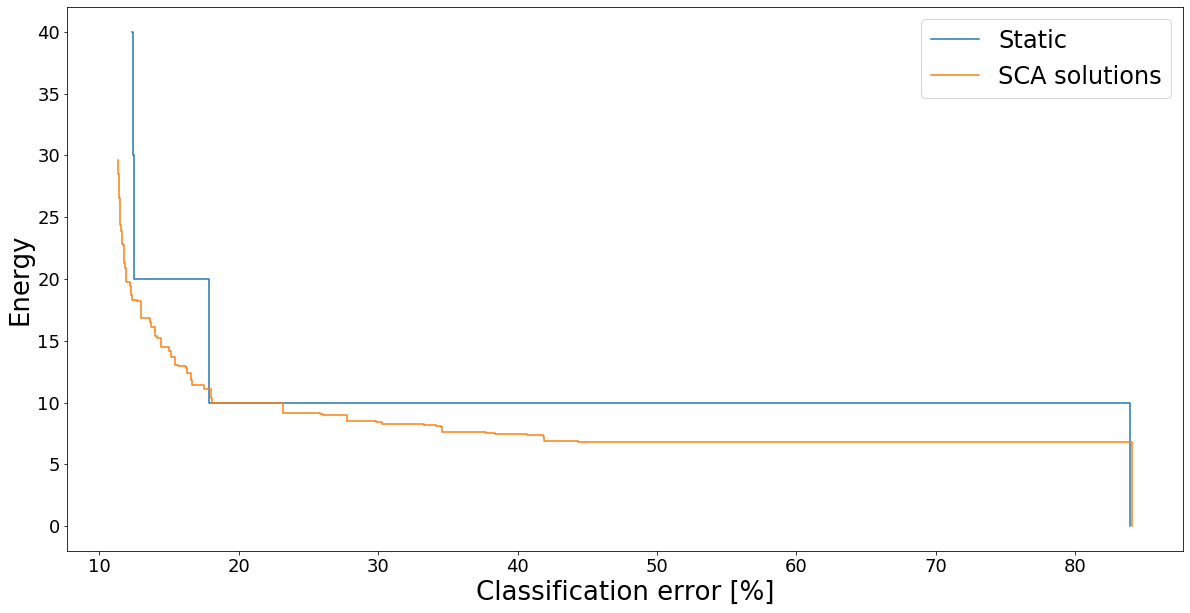

In [27]:
util.draw_tradeoffs([values, values_sca], 
                ["Static", "SCA solutions"])

Display a SCA assignment is a nice formatted way.

In [47]:
sensor_list = ["acc","mag","pressure","gyr","ori"]
def display_assignment(index, letter=""):
    config,acc,energy = solutions_sca[index], values_sca[index][0], values_sca[index][1]
    length = len(sensor_list)
    print (" "*9+" ".join(sensor_list))
    for i,a in enumerate(optimizer.contexts):
        cfg = " ".join([("{0:>"+str(len(s))+"}").format(str(config[i][j])) for j,s 
                        in enumerate(sensor_list)])
        print ("%7s: %s" % (a, cfg))
    print ("Accuracy: %1.3f     Energy: %1.1f"%(acc,energy))
    if len(letter)>0:
        return (acc,energy, letter)

In [29]:
display_assignment(50)

         acc mag pressure gyr ori
   Bike:   1   0        0   0   0
    Bus:   1   1        0   0   0
    Car:   1   1        0   0   0
    Run:   1   0        0   0   0
  Still:   1   0        0   0   0
 Subway:   1   0        0   0   0
  Train:   1   1        0   0   0
Walking:   1   0        0   0   0
Accuracy: 0.856     Energy: 14.5


### Cost-sensitive decision trees

The examples above showed how to change sensing settings based on the last classified context. An alternative is to change such settings based on the last feature data. This can be accomplished using the cost-sensitive decision trees adapted for the context recognition task. Such trees work by calculating only a subset of features in order to minimize the cost of attaining and calculating them. Based on the current branch used during the classification, different feature subset may be active for next instance.

In [30]:
from eecr import CostSensitiveTree
import pandas as pd

We start by defining a toy dataset for activity recognition. Attribute values are inspired by real sensors, but are modified so most attributes can only distinguish between two different activities. 

In [31]:
activities = ["still", "walk", "walk","run","run","car","car","subway","subway","still"]
gps_velocity = [1,0,1,0,1,66,68,66,68,0]
acc_motion = [1,4,5,4,5,0,1,0,1,0]
acc_period = [4,5,4,10,11,5,4,5,4,5]
mag_field = [49,48,49,48,49,48,49,102,203,48]
data = pd.DataFrame()
data["gps_velocity"] = gps_velocity
data["acc_motion"] = acc_motion
data["acc_period"] = acc_period
data["mag_field"] = mag_field
data["activity"] = activities
x = data.drop(["activity"], axis=1)
y = data["activity"]
contexts = y.unique()

In [32]:
data

gps_velocity  acc_motion  acc_period  mag_field activity
0             1           1           4         49    still
1             0           4           5         48     walk
2             1           5           4         49     walk
3             0           4          10         48      run
4             1           5          11         49      run
5            66           0           5         48      car
6            68           1           4         49      car
7            66           0           5        102   subway
8            68           1           4        203   subway
9             0           0           5         48    still

Next we define which attributes belong to which sensors and their respective costs. Attributes that belong to the same sensor will have the same cost, regardless of how many of them are active. 

In [33]:
feature_groups = {"acc": ["acc_motion", "acc_period"], "gps": ["gps_velocity"], "mag":["mag_field"]}

def sensor_costs(sensor_list):
    #print(sensor_list)
    cost = 20 #Base cost
    if "acc" in sensor_list:
        cost += 10
    if "gps" in sensor_list:
        cost+=30
    if "mag" in sensor_list:
        cost+=15
    #print (cost)
    return cost

A cost sensitive tree is created and fitted with the data.

In [34]:
tree = CostSensitiveTree(contexts, sensor_costs, feature_groups=feature_groups, weight = 0.01)
tree.fit(x,y)

We would expect that classifying the original data will yield the original label sequence and it does. 

In [35]:
tree.predict(x)

['still',
 'walk',
 'walk',
 'run',
 'run',
 'car',
 'car',
 'subway',
 'subway',
 'still']

The resulting tree can be visualized in two different layers of abstraction. 

In [36]:
tree.show()

acc_motion == 1
  mag_field == 49
    gps_velocity == 1
       --> still
    gps_velocity == 68
       --> car
  mag_field == 203
     --> subway
acc_motion == 4
  acc_period == 5
     --> walk
  acc_period == 10
     --> run
acc_motion == 5
  acc_period == 4
     --> walk
  acc_period == 11
     --> run
acc_motion == 0
  mag_field == 48
    gps_velocity == 66
       --> car
    gps_velocity == 0
       --> still
  mag_field == 102
     --> subway


In [37]:
tree.show_sensors()

acc
  ---> ['walk', 'run']
  mag
    ---> ['subway']
    gps
      ---> ['still', 'car']
  mag
    ---> ['subway']
    gps
      ---> ['still', 'car']



Finally, we show that if we increase the weights, some sensors cease to be used. GPS is the most expensive and is the first one to go. 

In [38]:
tree = CostSensitiveTree(contexts, sensor_costs, feature_groups=feature_groups, weight = 0.019)
tree.fit(x,y)

In [39]:
tree.show_sensors()

acc
  ---> ['walk', 'run']
  mag
    ---> ['still', 'subway']
  mag
    ---> ['subway', 'car']



### Automatic settings generation

In [40]:
from sklearn.tree import DecisionTreeClassifier

In [41]:
classifier = DecisionTreeClassifier()

In [42]:
optimizer = EnergyOptimizer(y)

In [43]:
list(feature_groups)

['acc', 'gps', 'mag']

In [44]:
feature_groups =[["acc_motion", "acc_period"], ["gps_velocity"], ["mag_field"]]

In [45]:
def sensor_costs(setting):
    #print(setting)
    cost = 20 
    if setting[0] == 1:
        cost += 10
    if setting[1] == 1:
        cost+=30
    if setting[2] == 1:
        cost+=15
    return cost

In [46]:
classifiers = optimizer.add_subsets(x,y,x,y,classifier, feature_groups=feature_groups, n = 3, 
                     setting_fn_energy = sensor_costs)

TO BE CONTINUED...